In [1]:
import pandas as pd
import sys
import glob
import numpy as np
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as PC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

In [2]:
csv_filepath = "/pscratch/sd/o/ocankur/data/resource_usage_paper"

In [3]:
def get_duration(dataframe, seconds=10):
    # remove jobs that take less than 10 secs.
    dataframe["start_time"] = pd.to_datetime(dataframe["start"], unit='s', utc=True)
    dataframe["end_time"] = pd.to_datetime(dataframe["end"], unit='s', utc=True)
    dataframe["duration"] = dataframe["end_time"] - dataframe["start_time"]
    dataframe = dataframe[dataframe["duration"] > datetime.timedelta(0,seconds)]
    return dataframe

In [4]:
def preprocess_data(ldms_dataframe, sacct_dataframe, metric, percentage=True):
    """
    Remove jobs that take less than 10 seconds.
    Filter out completed jobs.
    Filter out 'nstaff' and 'nstaff_g'
    """
    
    print("Number of LDMS data points before preprocessing: ", len(ldms_dataframe.index))
    
    if percentage:
        if metric == "mem_copy_utilization" or metric == "gpu_utilization":
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 100]
        else:
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 1]
    
    sacct_dataframe = get_duration(sacct_dataframe, 10)
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff_g"]
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff"]
    
    # sacct_dataframe = sacct_dataframe[sacct_dataframe["state"] == "COMPLETED"]
    
    sacct_dataframe.rename(columns={'jobidraw': 'jobid'}, inplace=True)
    merged_ldms = ldms_dataframe.merge(sacct_dataframe, on=["ProducerName", "jobid", "step"])
    
    print("Number of LDMS data points after preprocessing: ", len(merged_ldms.index))
    
    return merged_ldms

In [5]:
df_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_ldms.pq")
df_sacct_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_saact.pq")
merged_ldms_gputil = preprocess_data(df_gputil, df_sacct_gputil, metric="gpu_utilization", percentage=True)

Number of LDMS data points before preprocessing:  116803958
Number of LDMS data points after preprocessing:  85987227


In [6]:
merged_ldms_gputil = merged_ldms_gputil[merged_ldms_gputil["Account"].str.contains("_g")]

## Temporal and spatial imbalance (WIP - Double check implementations)
Defined in A Holistic View of Memory Utilization on HPC Systems: Current and Future Trends and also used in Analyzing Resource Utilization in an HPC System: A Case Study of NERSC’s Perlmutter


- N is the number of nodes.
- T is the total runtime of the job.
- U_(n,t) is the utilization of resource r on node n at time t.

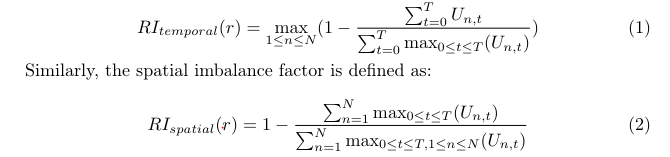

Temporal imbalance measures the difference between the actual resource usage over time and the maximum possible usage.

Spatial imbalance compares the maximum resource usage on each node to the maximum possible usage across all nodes. 

In [26]:
# Function to calculate temporal imbalance
def calculate_temporal_imbalance(df):
    jobid = df['jobid'].iloc[0]
    nodes = df['NodeList'].unique()
    temporal_imbalances = []

    # for node in nodes:
    #     node_df = df[df['NodeList'] == node]
    #     U_nt_sum = node_df['gpu_utilization'].sum()
    #     U_nt_max = node_df.groupby('#Time')['gpu_utilization'].max().sum()

        # print(f"Job ID: {jobid}, Node: {node}")
        # print(f"U_nt_sum (Sum of utilizations over time): {U_nt_sum}")
        # print(f"U_nt_max (Max utilization sum over time): {U_nt_max}")
        
#         if U_nt_max == 0:
#             temporal_imbalance = np.nan
#         else:
#             temporal_imbalance = 1 - (U_nt_sum / U_nt_max)
        
#         # print(f"Temporal imbalance for node {node}: {temporal_imbalance}\n")
#         temporal_imbalances.append(temporal_imbalance)
    
    U_nt_max = df.groupby('ProducerName')['gpu_utilization'].max().sum()
    U_nt_sum = df.groupby('ProducerName')['gpu_utilization'].sum().sum()

    if U_nt_max == 0:
        temporal_imbalance = np.nan
    else:
        temporal_imbalance = 1 - (U_nt_max / U_nt_sum)
    
    # display(temporal_imbalances)
    # max_temporal_imbalance = np.nanmax(temporal_imbalances)
    
    return pd.Series({'jobid': jobid, 'temporal_imbalance': temporal_imbalance})

# Function to calculate spatial imbalance
def calculate_spatial_imbalance(df):
    jobid = df['jobid'].iloc[0]
    N = df['NodeList'].nunique()

    if N == 0:
        return pd.Series({'jobid': jobid, 'spatial_imbalance': np.nan})

    U_nt_max = df.groupby('ProducerName')['gpu_utilization'].max().sum()
    U_n_max = df.groupby(['ProducerName', '#Time'])['gpu_utilization'].max().groupby('ProducerName').sum().sum()

    if U_n_max == 0:
        spatial_imbalance = np.nan
    else:
        spatial_imbalance = 1 - (U_nt_max / U_n_max)

    return pd.Series({'jobid': jobid, 'spatial_imbalance': spatial_imbalance})

In [27]:
# Calculate temporal imbalance for each job
temporal_imbalance = merged_ldms_gputil.groupby('jobid').apply(calculate_temporal_imbalance).reset_index(drop=True)
temporal_imbalance

,jobid,temporal_imbalance
0,13637517.0,0.998001
1,13637520.0,NaN
2,13829694.0,0.998868
3,13889527.0,NaN
4,13889532.0,0.999913
...,...,...
16139,14068349.0,0.984757
16140,14068350.0,0.159207
16141,14068352.0,0.979297
16142,14068358.0,0.981477


In [29]:
# Calculate spatial imbalance for each job
spatial_imbalance = merged_ldms_gputil.groupby('jobid').apply(calculate_spatial_imbalance).reset_index(drop=True)
spatial_imbalance

,jobid,spatial_imbalance
0,13637517.0,0.998001
1,13637520.0,NaN
2,13829694.0,0.996879
3,13889527.0,NaN
4,13889532.0,0.999671
...,...,...
16139,14068349.0,0.947033
16140,14068350.0,0.109450
16141,14068352.0,0.932902
16142,14068358.0,0.940552


In [30]:
# Merge the two imbalance results
imbalance_factors = pd.merge(temporal_imbalance, spatial_imbalance, on='jobid')

In [31]:
imbalance_factors

,jobid,temporal_imbalance,spatial_imbalance
0,13637517.0,0.998001,0.998001
1,13637520.0,NaN,NaN
2,13829694.0,0.998868,0.996879
3,13889527.0,NaN,NaN
4,13889532.0,0.999913,0.999671
...,...,...,...
16139,14068349.0,0.984757,0.947033
16140,14068350.0,0.159207,0.109450
16141,14068352.0,0.979297,0.932902
16142,14068358.0,0.981477,0.940552


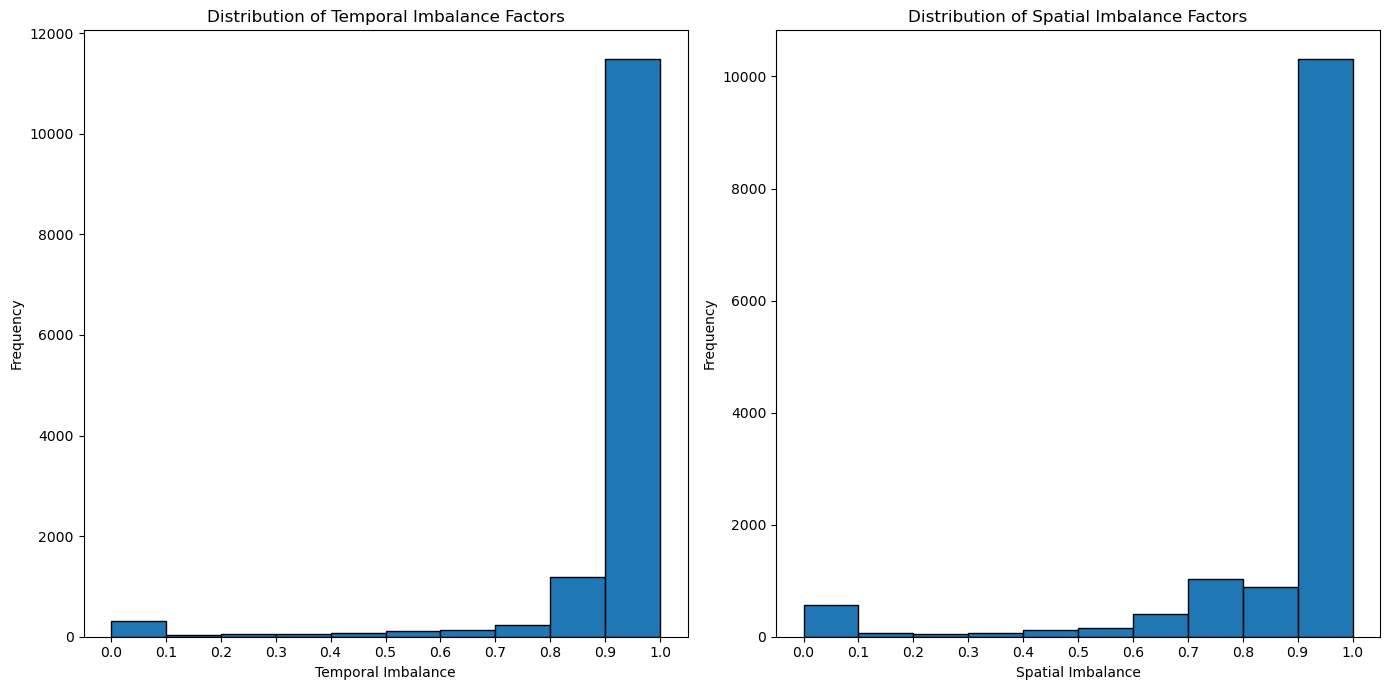

In [33]:
bins = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(14, 7))

# Temporal Imbalance
plt.subplot(1, 2, 1)
plt.hist(imbalance_factors['temporal_imbalance'].dropna(), bins=bins, edgecolor='black')
plt.title('Distribution of Temporal Imbalance Factors')
plt.xlabel('Temporal Imbalance')
plt.ylabel('Frequency')
plt.xticks(bins)

# Spatial Imbalance
plt.subplot(1, 2, 2)
plt.hist(imbalance_factors['spatial_imbalance'].dropna(), bins=bins, edgecolor='black')
plt.title('Distribution of Spatial Imbalance Factors')
plt.xlabel('Spatial Imbalance')
plt.ylabel('Frequency')
plt.xticks(bins)

plt.tight_layout()
plt.show()

## The coefficient of variation (CV) among different nodes for each job

In [41]:
# This function computes the mean GPU utilization for each node, and then calculates the CV of these means to assess the variability among nodes.
def calculate_cov(df):
    jobid = df['jobid'].iloc[0]
    utilizations = df.groupby('NodeList')['gpu_utilization'].mean().values

    if len(utilizations) > 1:
        cv = np.std(utilizations) / np.mean(utilizations)
    else:
        cv = np.nan

    return pd.Series({'jobid': jobid, 'cov': cv})

In [36]:
cov = merged_ldms_gputil.groupby('jobid').apply(calculate_cov).reset_index(drop=True)

/tmp/ipykernel_2034397/3634047377.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.std(utilizations) / np.mean(utilizations)
/tmp/ipykernel_2034397/3634047377.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.std(utilizations) / np.mean(utilizations)
/tmp/ipykernel_2034397/3634047377.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.std(utilizations) / np.mean(utilizations)
/tmp/ipykernel_2034397/3634047377.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.std(utilizations) / np.mean(utilizations)
/tmp/ipykernel_2034397/3634047377.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.std(utilizations) / np.mean(utilizations)
/tmp/ipykernel_2034397/3634047377.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cv = np.std(utilizations) / np.mean(utilizations)
/tmp/ipykernel_2034397/3634047377.py:6: RuntimeWarning: invalid value encountered in dou

In [37]:
cov

,jobid,cov
0,13637517.0,NaN
1,13637520.0,NaN
2,13829694.0,0.645099
3,13889527.0,NaN
4,13889532.0,NaN
...,...,...
16139,14068349.0,NaN
16140,14068350.0,1.000000
16141,14068352.0,NaN
16142,14068358.0,NaN


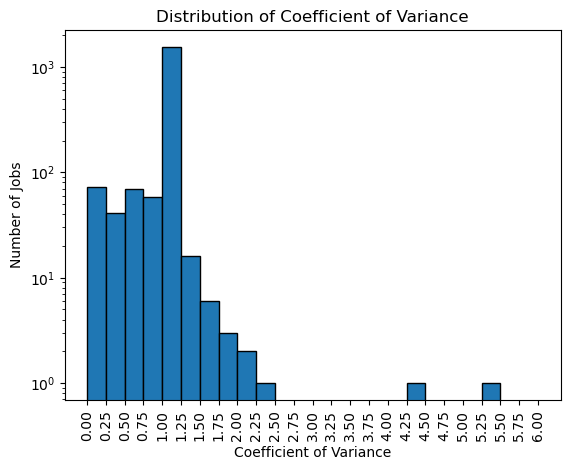

In [47]:
bins = np.arange(0, 6.25, 0.25)

plt.hist(cov['cov'].dropna(), bins=bins, edgecolor='black')
plt.title('Distribution of Coefficient of Variance')
plt.xlabel('Coefficient of Variance')
plt.ylabel('Number of Jobs')
plt.xticks(bins)
plt.xticks(bins, rotation=90) 
plt.yscale('log')
plt.show()